In [1]:
import pandas as pd
from fuzzywuzzy import process, fuzz
import re
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import fuzz
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components


In [2]:
# Load the food consumption data
food_consumption_data = pd.read_csv("data/chronic_consumption_gday_allsubjects.csv", encoding="utf-16")

# Load the SuEatableLife dataset
df_wf = pd.read_excel("data/sueatablelife_dataset.xlsx", sheet_name="SEL WF for users")
df_cf = pd.read_excel("data/sueatablelife_dataset.xlsx", sheet_name="SEL CF for users")

In [4]:
# Function to normalize labels
def normalize_label(s):
    s = s.lower().strip().replace('-', ' ').replace('_', ' ')
     # Remove numbers and letters in brackets, asteriks, punctuation
    s = re.sub(r'\(.*?\)', '', s)  # Remove text in brackets
    s = re.sub(r'\d+', '', s)  # Remove numbers
    s = re.sub(r'\*', '', s)  # Remove asterisks
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)       # drop punctuation
    s = re.sub(r'\b(semi[- ]skimmed|organic|low[- ]fat)\b', '', s)
    s = re.sub(r'\s+', ' ', s)               # collapse whitespace
    s = s.strip()  # Remove leading and trailing whitespace

    return s

In [7]:
# changing the name of a column in the food consumption data to match the SuEatableLife dataset
food_consumption_data.rename(columns={"Exposure hierarchy (L5)": 'Food commodity ITEM'}, inplace=True)

food_consumption_data

,Survey's country,Survey start year,Survey name,Population Group (L2),Exposure hierarchy (L1),Exposure hierarchy (L2),Exposure hierarchy (L3),Exposure hierarchy (L4),Food commodity ITEM,Exposure hierarchy (L6),...,Number of consumers,Mean,Standard Deviation,5th percentile,10th percentile,Median,95th percentile,97.5th percentile,99th percentile,Comment
0,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Beer and beer-like beverage,Beer,Beer,Beer,Beer,...,9,8.40,79.01,0.0,0.0,0.0,0.00,7.88,165.00,"'Number of observations lower than 298, the 99..."
1,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Liqueurs,Liqueurs,Liqueurs,Liqueurs,...,2,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
2,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Unsweetened spirits,Spirits from fruit,Spirits made from fruits other than stone fruits,Spirits made from fruits other than stone fruits,...,1,0.05,0.75,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
3,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,Sparkling wine,Sparkling wine,Sparkling wine,...,1,0.08,1.28,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
4,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, red","Wine, red","Wine, red",...,16,1.19,15.21,0.0,0.0,0.0,0.09,0.12,2.96,"'Number of observations lower than 298, the 99..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit",Soft drink with bitter principle,...,2,0.58,5.11,0.0,0.0,0.0,0.00,0.00,42.20,"'Number of observations lower than 180, the 97..."
1485,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, flavoured, no fruit",...,1,1.03,12.81,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 180, the 97..."
1486,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, lemon flavour",...,1,0.90,11.21,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 180, the 97..."
1487,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, with fruit juice (fruit content be...","Fruit soft drink, orange",...,2,0.91,8.14,0.0,0.0,0.0,0.00,0.00,64.95,"'Number of observations lower than 180, the 97..."


In [6]:
# group same foods in the food consumption data
df_fcd_grouped = food_consumption_data.groupby("Food commodity ITEM")["Mean"].sum().reset_index()

df_fcd_grouped

,Food commodity ITEM,Mean
0,Alcoholic sauce,0.03
1,Alcopop and flavoured wine,1.40
2,"Algae based formulations (e.g. Spirulina, chlo...",0.02
3,Almond drink,3.68
4,Almonds,3.75
...,...,...
573,Yeast bread – pizza dough,57.49
574,Yeast leavened pastry,0.54
575,"Yoghurt drinks, including sweetened and/or fla...",3.76
576,"Yoghurt, cow milk",61.49


In [8]:
# keep only the relevant columns
df_fcd_grouped = df_fcd_grouped[["Food commodity ITEM", "Mean"]]
df_wf = df_wf[["Food commodity ITEM", "Water Footprint liters water/kg o liter of food ITEM"]]
df_cf = df_cf[["Food commodity ITEM", "Carbon Footprint kg CO2eq/kg or l of food ITEM"]]

In [9]:
df_cf

,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM
0,BEER IN CAN,0.693000
1,BEER IN GLASS,0.960500
2,BEER MODULAR CAN,0.530600
3,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000
4,SIMPLE COOKIES**,1.390750
...,...,...
319,OCTOPUS,5.800000
320,SQUID,6.910000
321,PRAWNS/SHRIMPS,7.040000
322,OCTOPUS (F),7.878611


In [ ]:
# Normalize the food labels in the dataframes

for df in [df_cf, df_wf, df_fcd_grouped]:
    df['clean_label'] = df["Food commodity ITEM"].apply(normalize_label)

,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,clean_label
0,BEER IN CAN,0.693000,beer in can
1,BEER IN GLASS,0.960500,beer in glass
2,BEER MODULAR CAN,0.530600,beer modular can
3,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,chocolate or cream filled cookies
4,SIMPLE COOKIES**,1.390750,simple cookies
...,...,...,...
319,OCTOPUS,5.800000,octopus
320,SQUID,6.910000,squid
321,PRAWNS/SHRIMPS,7.040000,prawns shrimps
322,OCTOPUS (F),7.878611,octopus


In [11]:
# Create a union of all clean labels from the three dataframes

all_labels = pd.concat([
    df_cf['clean_label'],
    df_wf['clean_label'],
    df_fcd_grouped['clean_label'],
]).drop_duplicates().reset_index(drop=True)

master = pd.DataFrame({'clean_label': all_labels})

master


,clean_label
0,beer in can
1,beer in glass
2,beer modular can
3,chocolate or cream filled cookies
4,simple cookies
...,...
1004,yeast bread pizza dough
1005,yeast leavened pastry
1006,yoghurt drinks including sweetened and or flav...
1007,yoghurt cow milk


In [15]:
# Try with graph method for clustering
# —— 1. Prepare your labels and embeddings ——
labels = master["clean_label"].tolist()              # list of N cleaned food labels
model  = SentenceTransformer("paraphrase-MiniLM-L6-v2")
embeddings = model.encode(labels, batch_size=64)     # shape: (N, D)

# —— 2. Compute pairwise cosine similarity ——
sim_matrix = cosine_similarity(embeddings)           # dense NxN matrix

# —— 3. Build sparse adjacency for sim > threshold ——
threshold = 0.85
# Create a Boolean mask (drop self-loops if you like)
adj_bool = (sim_matrix > threshold).astype(int)
np.fill_diagonal(adj_bool, 0)

# Convert to CSR (compressed sparse row) matrix
graph = csr_matrix(adj_bool)

# —— 4. Extract connected components —— 
#    n_components = number of clusters
#    comp_labels  = array of length N giving component ID for each node i
n_components, comp_labels = connected_components(
    csgraph=graph,
    directed=False,
    return_labels=True
)

# —— 5. Build human-readable clusters ——
clusters = {}
for idx, comp_id in enumerate(comp_labels):
    clusters.setdefault(comp_id, []).append(labels[idx])

# —— 6. (Optional) Inspect clusters —— 
for comp_id, members in clusters.items():
    print(f"\nCluster {comp_id} ({len(members)} items):")
    print("  ", members)


Cluster 0 (1 items):
   ['beer in can']

Cluster 1 (2 items):
   ['beer in glass', 'beer']

Cluster 2 (1 items):
   ['beer modular can']

Cluster 3 (1 items):
   ['chocolate or cream filled cookies']

Cluster 4 (1 items):
   ['simple cookies']

Cluster 5 (2 items):
   ['mineral water', 'natural mineral water']

Cluster 6 (1 items):
   ['bread multicereal']

Cluster 7 (11 items):
   ['bread plain', 'bread whole', 'bread', 'bread alternative', 'crisp bread', 'crisp bread wheat refined flour', 'mixed wheat and rye bread and rolls', 'wheat bread and rolls brown or wholemeal', 'wheat bread and rolls semi brown', 'wheat bread and rolls white', 'wheat crisp bread']

Cluster 8 (1 items):
   ['bread frozen']

Cluster 9 (1 items):
   ['cornflakes']

Cluster 10 (8 items):
   ['dark chocolate', 'milk chocolate', 'chocolate', 'bitter chocolate', 'chocolate cake', 'chocolate spread', 'filled chocolate', 'white chocolate']

Cluster 11 (1 items):
   ['coffee ground']

Cluster 12 (1 items):
   ['coffe

In [16]:
# STEP 2: Build a Canonical Mapping
# ==========================================================
# For each cluster, choose a canonical representative.
# Here, we'll choose the first label in each cluster as the representative.
canonical_map = {}
for comp_id, members in clusters.items():
    # Choose the representative (here, the first member)
    representative = members[0]
    # Map every label in this cluster to this representative
    for label in members:
        canonical_map[label] = representative

In [19]:
# STEP 3: Map Each Source DataFrame to the Canonical Label
# ==========================================================
# Assume you have three DataFrames: df_cf, df_wf, and df_fcd_grouped.
# Each must have a "clean_label" column that was processed the same way as in master.

def assign_standard_label(df, mapping_dict, label_col="clean_label"):
    """
    Create a new column 'standard_label' in the dataframe by mapping the clean_label
    via the mapping_dict. If a label is not found, retain the original label.
    """
    df["standard_label"] = df[label_col].map(mapping_dict)
    # Optionally fill missing mappings with the original clean label.
    df["standard_label"].fillna(df[label_col], inplace=True)
    return df

df_cf = assign_standard_label(df_cf, canonical_map)
df_wf = assign_standard_label(df_wf, canonical_map)
df_fcd_grouped = assign_standard_label(df_fcd_grouped, canonical_map)

C:\Users\casaz\AppData\Local\Temp\ipykernel_10016\1089131301.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["standard_label"].fillna(df[label_col], inplace=True)
C:\Users\casaz\AppData\Local\Temp\ipykernel_10016\1089131301.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [22]:
# STEP 4: Merge the Datasets on 'standard_label'
# ==========================================================
from functools import reduce

# Put the dataframes into a list. Adjust this list to include all your data sources.
dfs = [df_cf, df_wf, df_fcd_grouped]

# Perform an outer merge on the "standard_label" column.
merged = reduce(lambda left, right: pd.merge(left, right, on="standard_label", how="outer"), dfs)

# (Optional) Inspect the merged DataFrame
print("Merged DataFrame shape:", merged.shape)
merged.head()

Merged DataFrame shape: (1357, 10)


,Food commodity ITEM_x,Carbon Footprint kg CO2eq/kg or l of food ITEM,clean_label_x,standard_label,Food commodity ITEM_y,Water Footprint liters water/kg o liter of food ITEM,clean_label_y,Food commodity ITEM,Mean,clean_label
0,NaN,NaN,NaN,alcoholic sauce,NaN,NaN,NaN,Alcoholic sauce,0.03,alcoholic sauce
1,NaN,NaN,NaN,alcopop and flavoured wine,NaN,NaN,NaN,Alcopop and flavoured wine,1.40,alcopop and flavoured wine
2,ALFONSINO,3.49,alfonsino,alfonsino,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,algae based formulations,NaN,NaN,NaN,"Algae based formulations (e.g. Spirulina, chlo...",0.02,algae based formulations
4,ALMOND,1.88,almond,almond,ALMOND SHELLED,16095.0,almond shelled,Almonds,3.75,almonds


In [23]:
merged_notna = merged.dropna()

In [24]:
# plot the top 15 consumed products
""" food_consumption_data_nowater = food_consumption_data[
    (food_consumption_data["Exposure hierarchy (L7)"] != "Natural mineral water") &
    (food_consumption_data["Exposure hierarchy (L7)"] != "Tap water") &
    (food_consumption_data["Exposure hierarchy (L7)"] != "Filtered tap water")] """

top15 = (
    merged_notna
    .sort_values('Mean', ascending=False)
    .head(15)
)

top15

,Food commodity ITEM_x,Carbon Footprint kg CO2eq/kg or l of food ITEM,clean_label_x,standard_label,Food commodity ITEM_y,Water Footprint liters water/kg o liter of food ITEM,clean_label_y,Food commodity ITEM,Mean,clean_label
372,BUFFALO MILK,3.57000,buffalo milk,buffalo milk,COW MILK,1260.5,cow milk,Cow milk,307.48,cow milk
373,COW MILK,1.30500,cow milk,buffalo milk,COW MILK,1260.5,cow milk,Cow milk,307.48,cow milk
1230,TOMATO PUREE,1.03110,tomato puree,tomato chopped,TOMATO PEELED,267.0,tomato peeled,Tomatoes,134.18,tomatoes
1248,TOMATO (G),2.42500,tomato,tomato chopped,TOMATO PUREE,713.0,tomato puree,Tomatoes,134.18,tomatoes
1218,TOMATO PEELED,1.29890,tomato peeled,tomato chopped,TOMATO PUREE,713.0,tomato puree,Tomatoes,134.18,tomatoes
1215,TOMATO PEELED,1.29890,tomato peeled,tomato chopped,TOMATO PEELED,267.0,tomato peeled,Tomatoes,134.18,tomatoes
1206,TOMATO CHOPPED,1.47275,tomato chopped,tomato chopped,TOMATO,41.0,tomato,Tomatoes,134.18,tomatoes
1221,TOMATO PEELED,1.29890,tomato peeled,tomato chopped,TOMATO,41.0,tomato,Tomatoes,134.18,tomatoes
1224,TOMATO PUREE,1.03110,tomato puree,tomato chopped,TOMATO JUICE,267.0,tomato juice,Tomatoes,134.18,tomatoes
1245,TOMATO (G),2.42500,tomato,tomato chopped,TOMATO PEELED,267.0,tomato peeled,Tomatoes,134.18,tomatoes


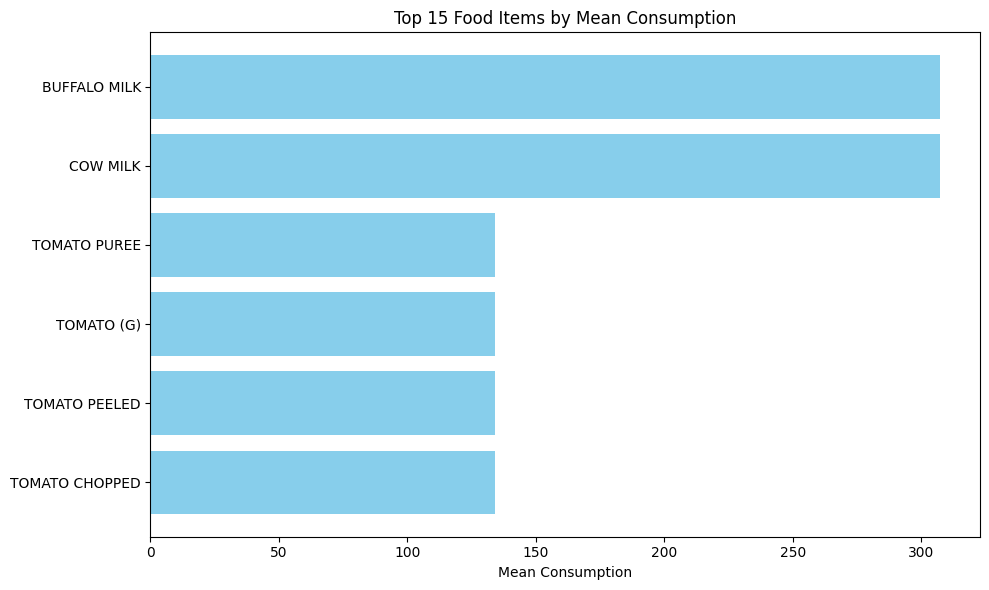

In [25]:

# Extract lists
selected_variables = top15["Food commodity ITEM_x"].tolist()
selected_values = top15["Mean"].tolist()

# Create a bar plot for the top 15 food items
plt.figure(figsize=(10, 6))
plt.barh(selected_variables, selected_values, color='skyblue')
plt.xlabel('Mean Consumption')
plt.title('Top 15 Food Items by Mean Consumption')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.tight_layout()
plt.show()